# 0. Parameters & Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from functions.epsilon_greedy_agent import train_agent_epsilon_greedy
from functions.ucb_agent import train_ucb_agent
from functions.dummy_agent import train_dummy_agent
from functions.gradient_agent import train_agent_gradient

In [9]:
# Fix the seed
np.random.seed(1)
# Number of agents
C_N_AGENTS = 2000
# Number of time steps
C_N_ITER = 1000
# Learning-rate
C_LEARNING_RATE = 0.1
# Signal to Noise Ratio in dB
C_SNR_DB = 11
print(f"Selected SNR = {C_SNR_DB} dB")
# Birates
bitrates = np.array([2520, 840, 360, 168])

Selected SNR = 11 dB


# 1. Packet Error Rate vs. Signal to Noise Ratio curves

In [10]:
df = pd.read_csv('data/TEP_vs_SNR.csv')
labels = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"]

df_per = pd.DataFrame()
df_per['SNR'] = df.T.index[1:]
df_per['TEP_DSSS1'] = df.T[0].to_list()[1:]
df_per['TEP_DSSS3'] = df.T[1].to_list()[1:]
df_per['TEP_DSSS7'] = df.T[2].to_list()[1:]
df_per['TEP_DSSS15'] = df.T[3].to_list()[1:]

In [11]:
df.head()

,SNR,-5,-3,-1,1,3,5,7,9,11,13,15,17,19,21,23
0,TEP_DSSS1,1,1.00,1.0000,1.0000,1.000,1.00000,1.00000,0.9950,0.99000,0.98000,0.965,0.94,0.925,0.91,0.900
1,TEP_DSSS3,1,1.00,1.0000,1.0000,0.980,0.82000,0.60000,0.4600,0.35000,0.28000,0.240,0.21,0.190,0.18,0.175
2,TEP_DSSS7,1,1.00,0.9825,0.8425,0.485,0.16625,0.05375,0.0175,0.00875,0.00375,0.000,0.00,0.000,0.00,0.000
3,TEP_DSSS15,1,0.93,0.5800,0.2000,0.040,0.01000,0.00000,0.0000,0.00000,0.00000,0.000,0.00,0.000,0.00,0.000


Text(0.5, 1.0, 'PER vs. SNR for different DSSS modulation schemes')

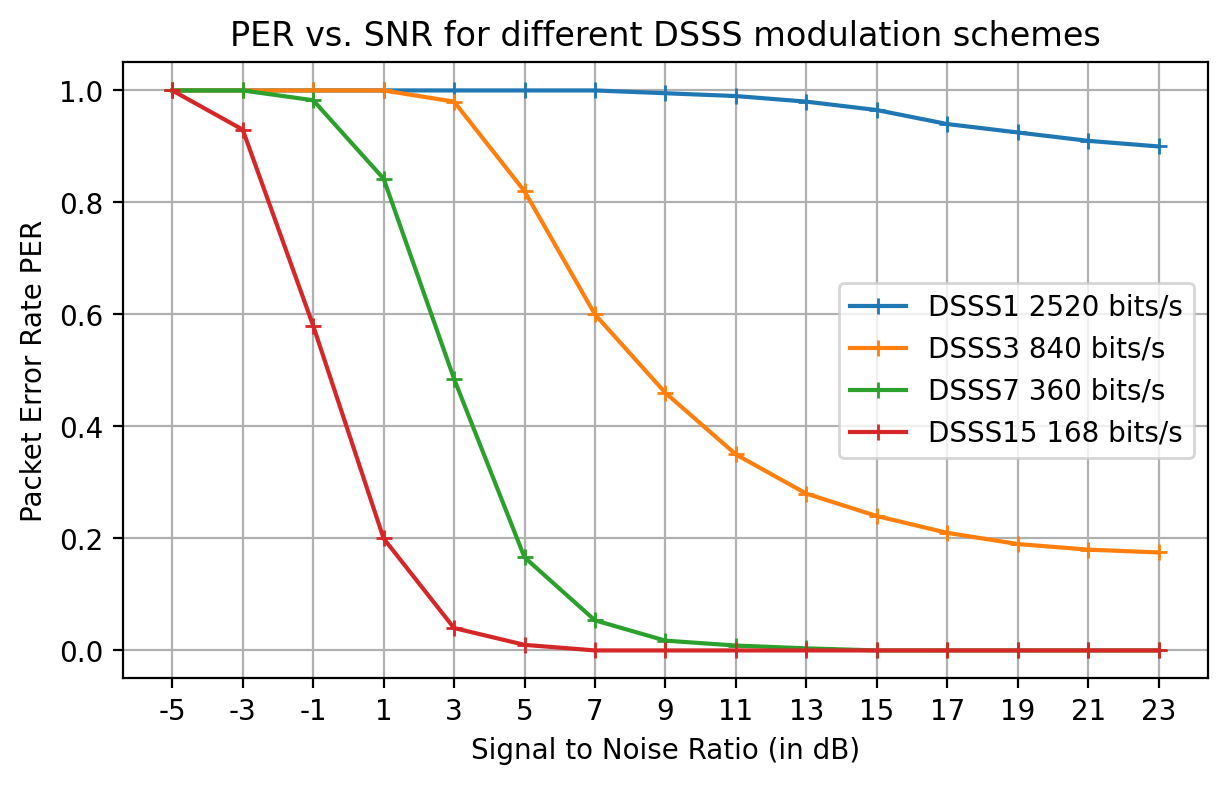

In [50]:
plt.figure(figsize=(7,4), dpi=200)
for k in range(4) :
    plt.plot(df_per['SNR'], df_per['TEP_' + labels[k]], label = labels[k] + " " + str(bitrates[k]) + " bits/s", marker = "+")
plt.xlabel("Signal to Noise Ratio (in dB)")
plt.ylabel("Packet Error Rate PER")
plt.legend(loc="best")
plt.grid()
plt.title("PER vs. SNR for different DSSS modulation schemes")

In [13]:
# PER and bitrates for each modulation method
per_values = df[str(C_SNR_DB)].to_numpy()
print("Selected Packet Error Rate values :", per_values)

Selected Packet Error Rate values : [0.99    0.35    0.00875 0.     ]


# $\epsilon$-greedy methods: choice of $\epsilon$

In [14]:
# List of epsilon values
eps_range = np.logspace(-4, 0, 10)
# Store the final rewards
final_rewards = []

# Compute the total reward for each epsilon
for eps in tqdm(eps_range):
    
    # Get the rewards list
    rewards, _, _ = train_agent_epsilon_greedy(per_values, bitrates, n_agents= C_N_AGENTS, n_iter= C_N_ITER, eps = eps, alpha = C_LEARNING_RATE)
    # Get the final reward
    final_reward = np.mean(rewards[-1, :])
    final_rewards.append(final_reward)

# Convert the list into a np.ndarray
final_rewards = np.array(final_rewards)
# Get the optimum value
eps_opt = eps_range[np.argmax(final_rewards)]
print(f"Optimal computed epsilon: {eps_opt:.3f}")

100%|██████████| 10/10 [01:31<00:00,  9.18s/it]

Optimal computed epsilon: 0.129


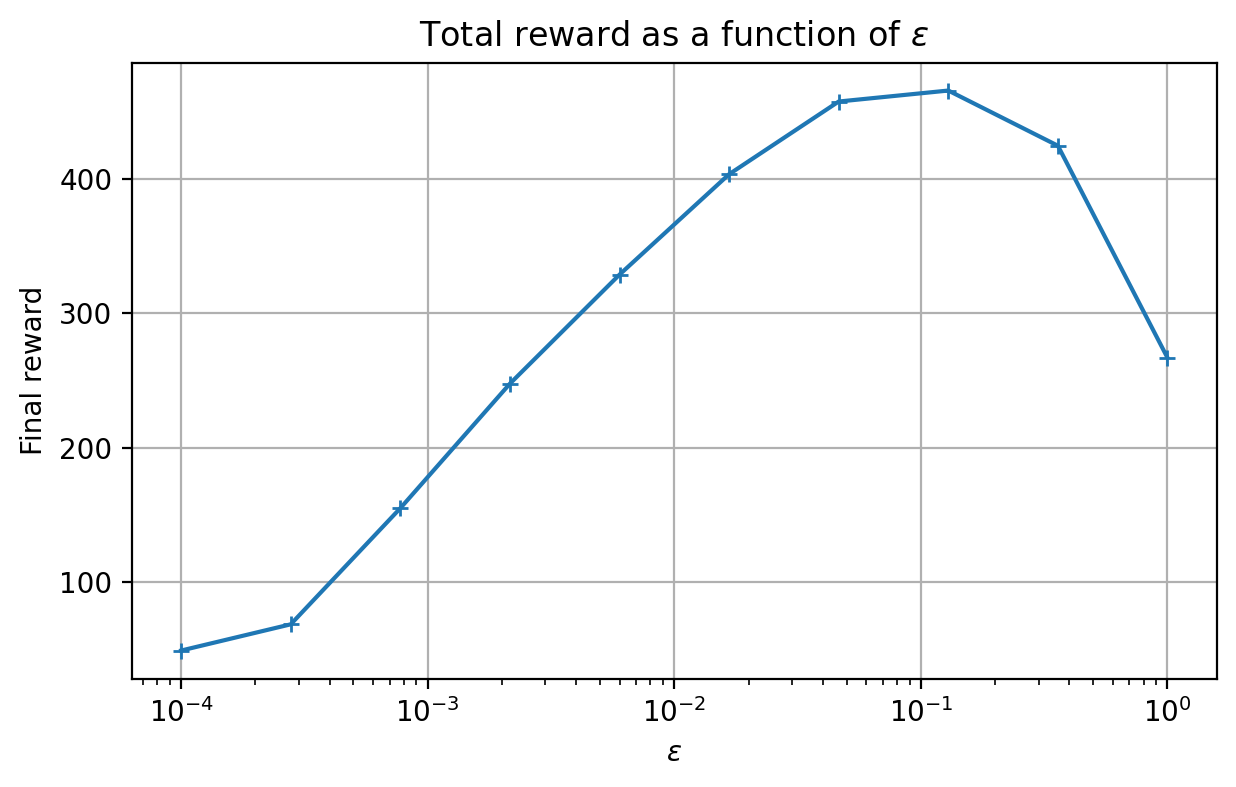

In [15]:
# Plot of the final reward as a function of epsilon
plt.figure(figsize=(7,4), dpi=200)
plt.semilogx(eps_range, final_rewards, marker = "+")
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'Final reward (in bits/s)')
plt.title(r'Total reward as a function of $\varepsilon$')
plt.grid()
plt.show()

100%|██████████| 4/4 [00:36<00:00,  9.16s/it]


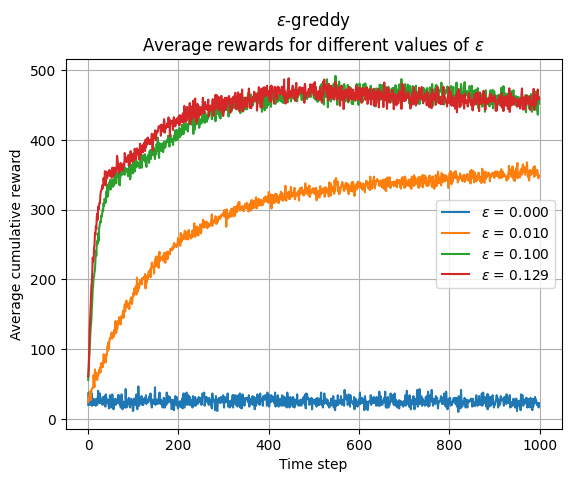

In [16]:
# Plot of mean rewards trajectories for epsilon = 0., 1e-2, 1e-1 and eps_opt
plt.figure(figsize=(7,4), dpi=200)
for epsilon in tqdm([0., 1e-2, 1e-1, eps_opt]) :

    # Get the rewards list
    rewards, _, _ = train_agent_epsilon_greedy(per_values, bitrates, n_agents = C_N_AGENTS, n_iter = C_N_ITER, eps = epsilon, alpha = C_LEARNING_RATE)
    plt.plot(np.mean(rewards, axis = 1), label = f"$\epsilon$ = {epsilon:.3f}")

plt.title(r'''$\varepsilon$-greddy
Average rewards for different values of $\varepsilon$''')
plt.xlabel("Time (in s)")
plt.ylabel("Average cumulative reward (in bits/s)")
plt.legend()
plt.grid()
plt.show()


# Upper Confidence Band: choice of parameter $c$

100%|██████████| 3/3 [00:52<00:00, 17.50s/it]


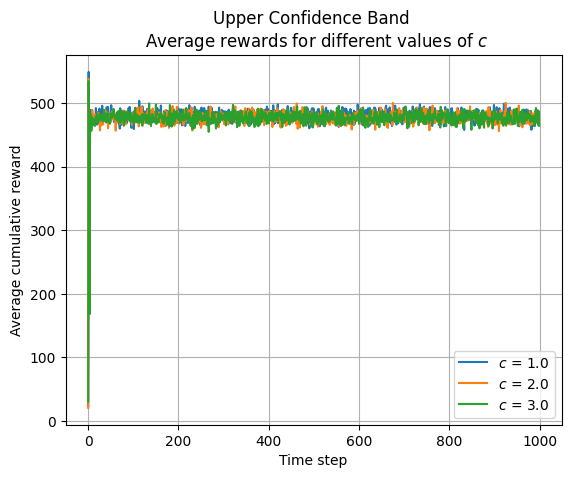

In [17]:
# List of c values
c_values = [1., 2., 3.]

plt.figure(figsize=(7,4), dpi=200)

for c in tqdm(c_values) :

    rewards, _, _ = train_ucb_agent(per_values, bitrates, n_agents = C_N_AGENTS, n_iter = C_N_ITER, c = c, alpha = C_LEARNING_RATE)
    plt.plot(np.mean(rewards, axis = 1), label = f"$c$ = {c:.1f}")

plt.title('Upper Confidence Band \n Average rewards for different values of $c$')
plt.xlabel("Time (in s)")
plt.ylabel("Average cumulative reward (in bits/s)")
plt.legend()
plt.grid()
plt.show()


# Gradient based mathod: choice of $\alpha$

In [18]:
# List of alpha values
alpha_values = np.logspace(-2, -1, 5)
# Store the final rewards
final_rewards = []

# Compute the total reward for each epsilon
for alpha in tqdm(alpha_values):
    
    # Get the rewards list
    rewards, _, _ = train_agent_gradient(per_values, bitrates, n_agents = C_N_AGENTS, n_iter = C_N_ITER, alpha_pref = alpha, alpha_rwd = C_LEARNING_RATE)
    # Get the final reward
    final_reward = np.mean(rewards[-1, :])
    final_rewards.append(final_reward)

# Convert the list into a np.ndarray
final_rewards = np.array(final_rewards)
# Get the optimum value
alpha_opt = alpha_values[np.argmax(final_rewards)]
print(f"Optimal computed alpha: {alpha_opt:.3f}")

100%|██████████| 5/5 [23:44<00:00, 284.94s/it]

Optimal computed alpha: 0.100


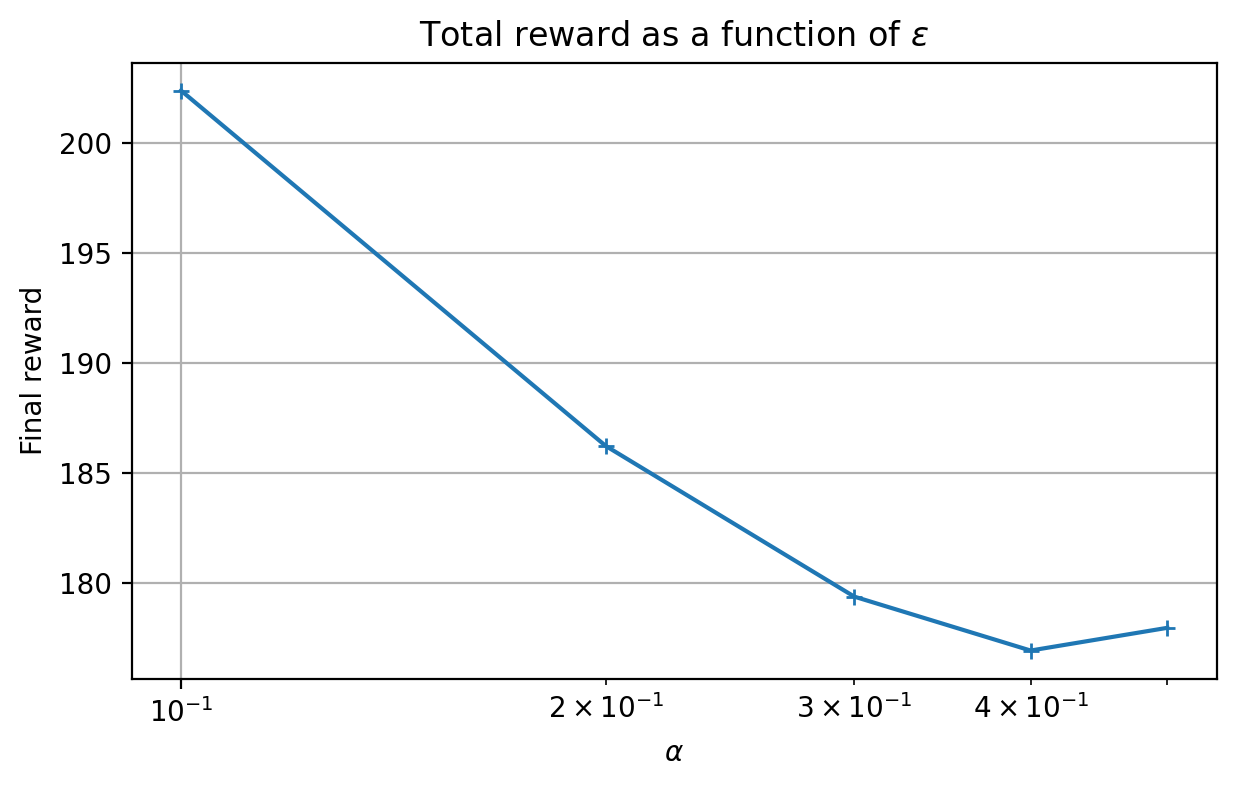

In [20]:
# Plot of the final reward as a function of epsilon
plt.figure(figsize=(7,4), dpi=200)
plt.semilogx(alpha_values, final_rewards, marker = "+")
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Final reward (in bits/s)')
plt.title(r'Total reward as a function of $\varepsilon$')
plt.grid()
plt.show()

# Best policy ? $\epsilon$-greedy vs. Upper Confidence Band vs. Gradient

In [21]:
# Epsilon-greedy
rewards_greedy, action_values_greedy, action_counts_greedy = train_agent_epsilon_greedy(per_values, bitrates, n_agents= C_N_AGENTS, n_iter= C_N_ITER, eps = eps_opt, alpha = C_LEARNING_RATE)

# Upper Confidence Band
rewards_ucb, action_values_ucb, action_counts_ucb = train_ucb_agent(per_values, bitrates, n_agents = C_N_AGENTS, n_iter = C_N_ITER, c = c, alpha = C_LEARNING_RATE)

# Gradient
rewards_gradient, proba_gradient, action_counts_gradient = train_agent_gradient(per_values, bitrates, n_agents = C_N_AGENTS, n_iter = C_N_ITER, alpha_pref = 0.1, alpha_rwd = C_LEARNING_RATE)

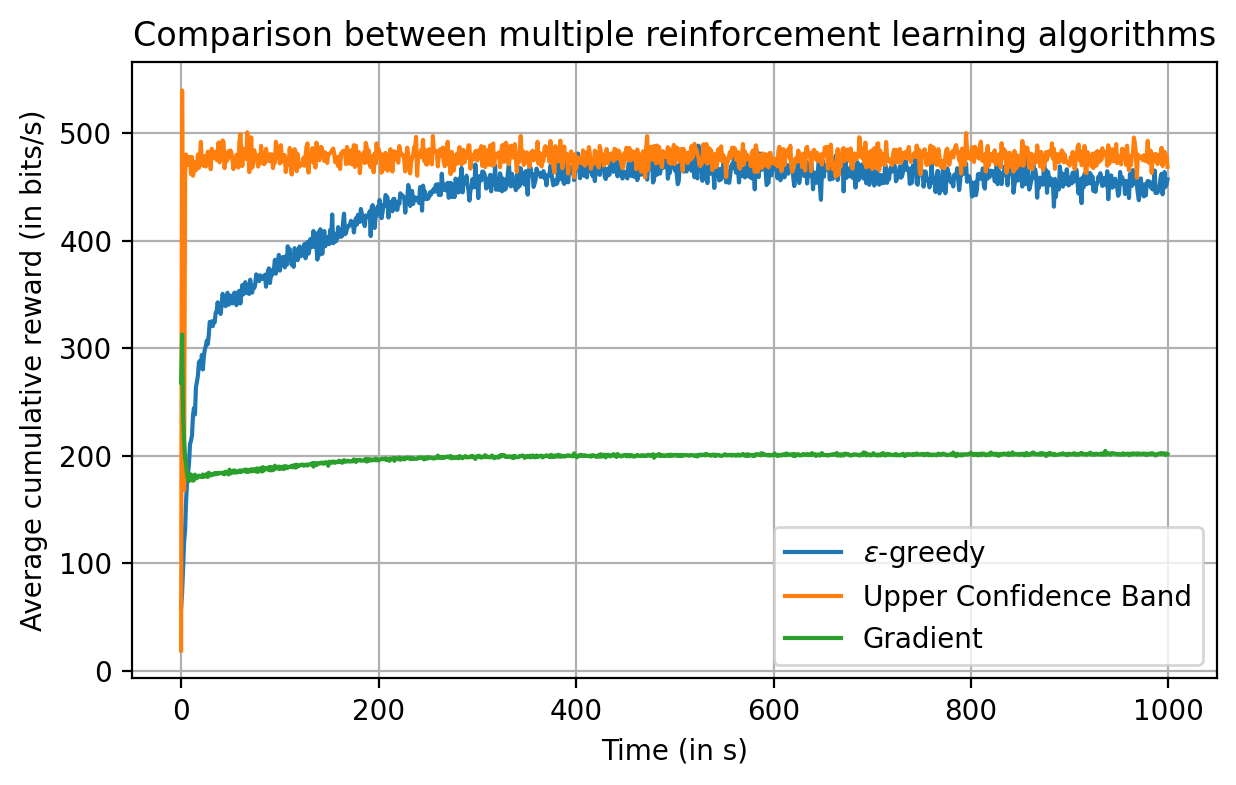

In [29]:
plt.figure(figsize=(7,4), dpi=200)
plt.plot(np.mean(rewards_greedy, axis = 1), label = f"$\epsilon$-greedy")
plt.plot(np.mean(rewards_ucb, axis = 1), label = f"Upper Confidence Band")
plt.plot(np.mean(rewards_gradient, axis = 1), label = f"Gradient")
plt.title("Comparison between multiple reinforcement learning algorithms")
plt.xlabel("Time (in s)")
plt.ylabel("Average cumulative reward (in bits/s)")
plt.grid()
plt.legend()


# Action-values estimates: mean over all agents

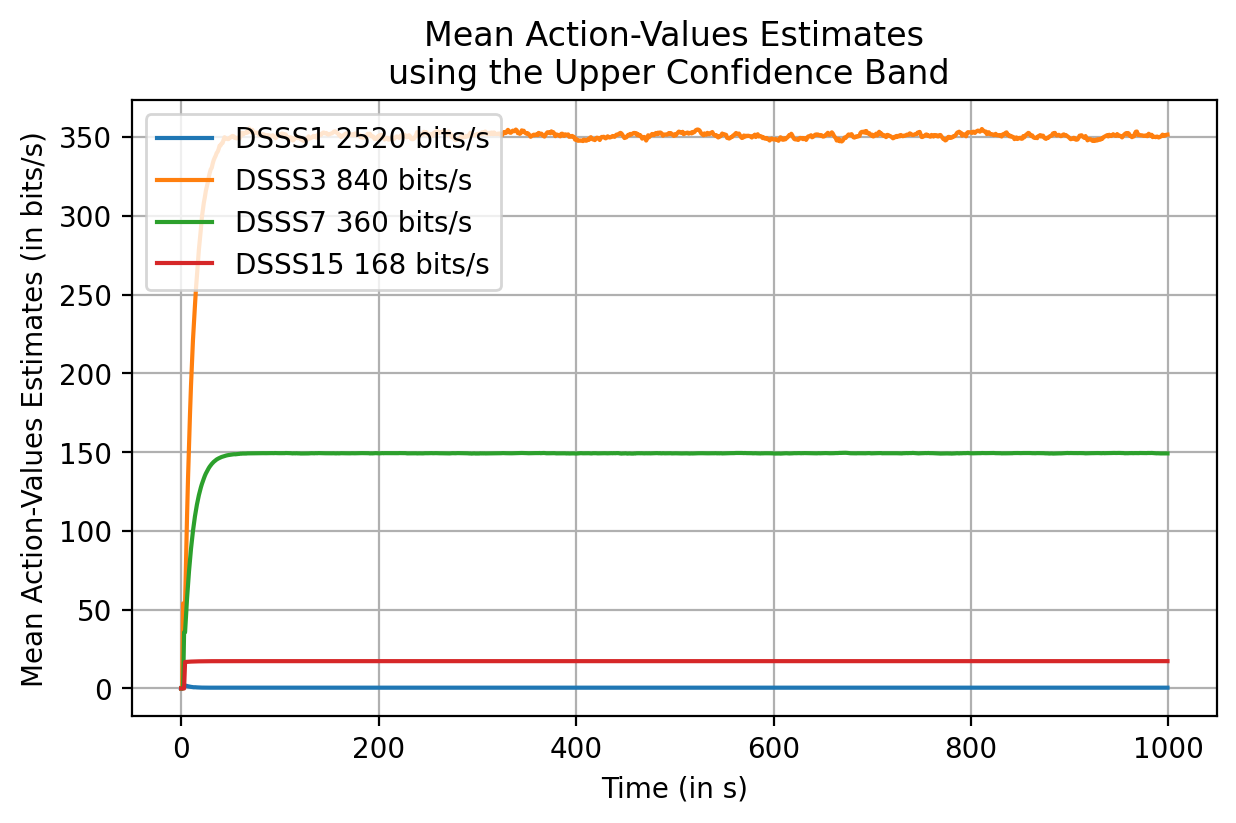

In [43]:
plt.figure(figsize=(7,4), dpi=200)
for k in range(4) :
    plt.plot(np.mean(action_values_ucb, axis = 1)[:, k], label = labels[k] + " " + str(bitrates[k]) + " bits/s")
plt.ylabel("Mean Action-Values Estimates (in bits/s)")
plt.xlabel("Time (in s)")
plt.title("Mean Action-Values Estimates\nusing the Upper Confidence Band ")
plt.legend()
plt.grid()

# Action-values estimates: comparison between agents

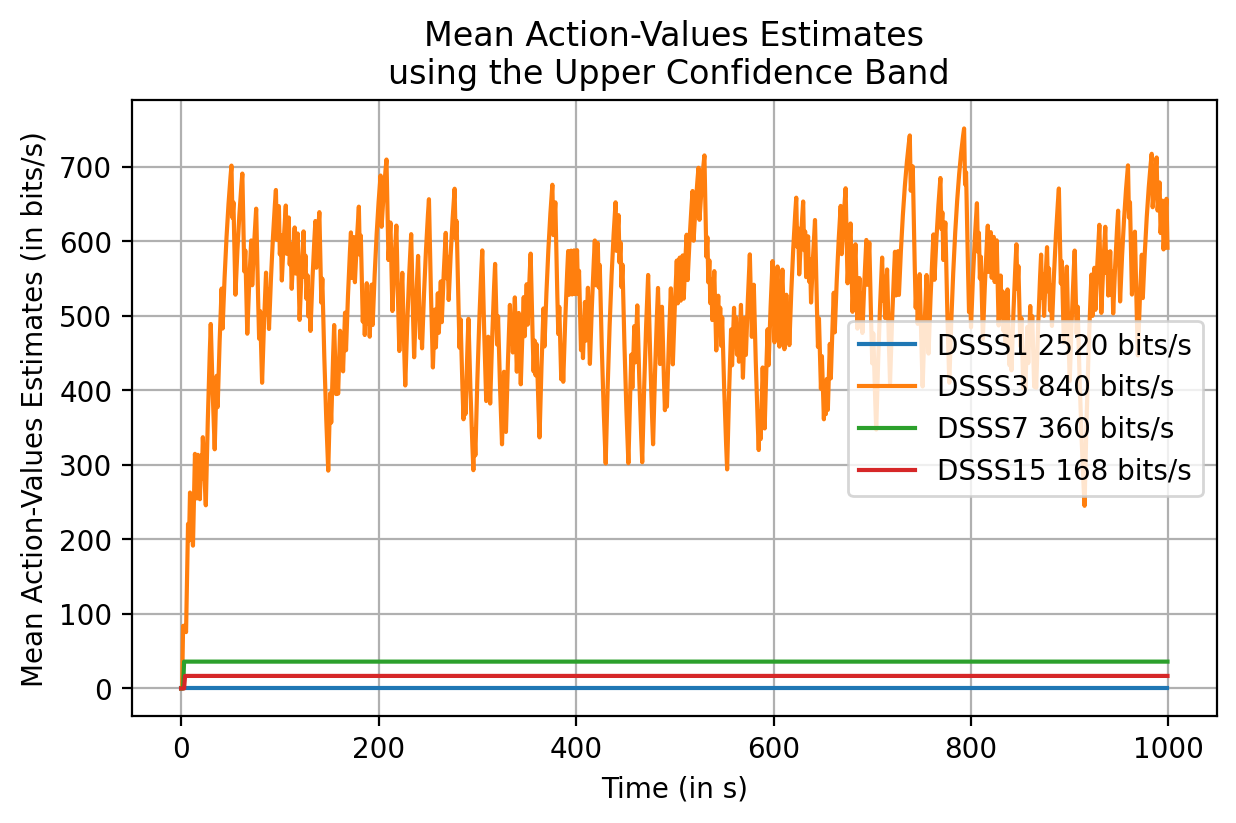

In [45]:
plt.figure(figsize=(7,4), dpi=200)
for k in range(4) :
    plt.plot(action_values_ucb[:, 1, k], label = labels[k] + " " + str(bitrates[k]) + " bits/s")
plt.ylabel("Mean Action-Values Estimates (in bits/s)")
plt.xlabel("Time (in s)")
plt.title("Mean Action-Values Estimates\nusing the Upper Confidence Band ")
plt.legend()
plt.grid()

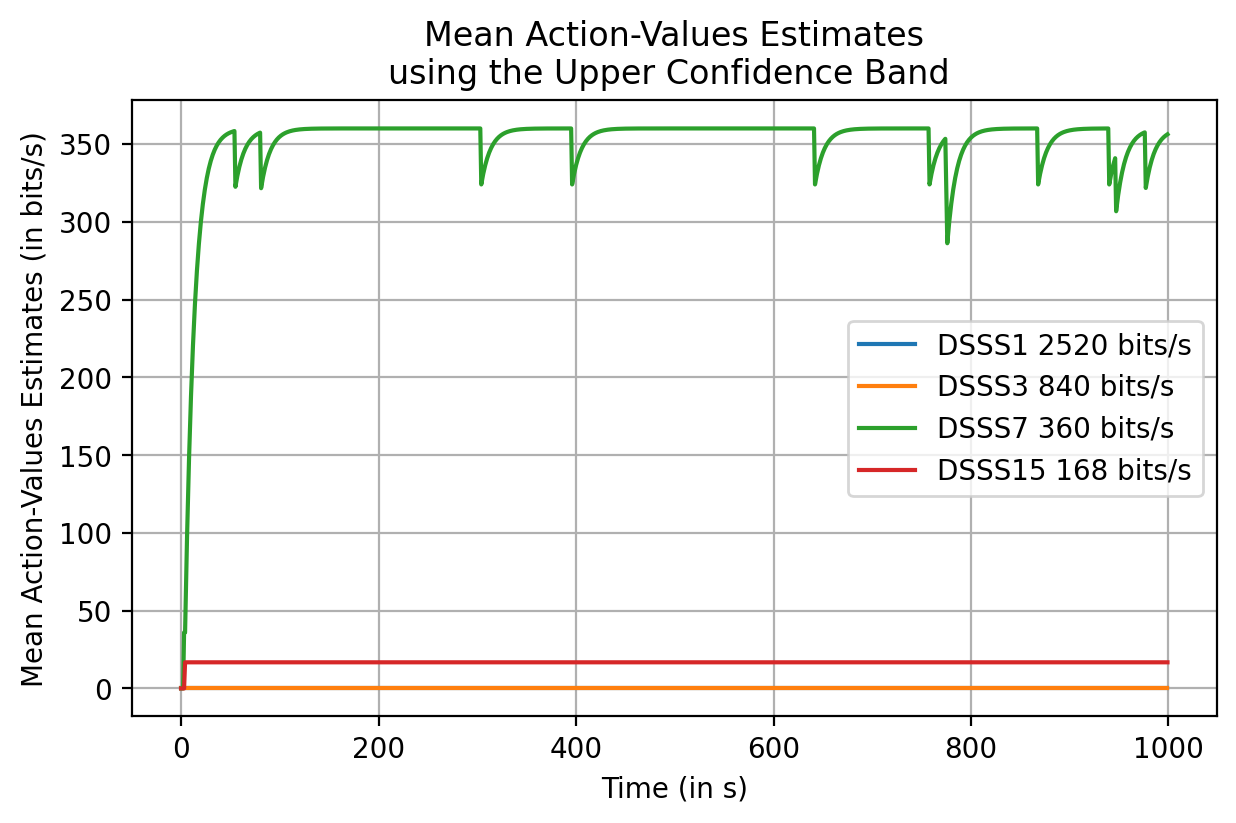

In [49]:
plt.figure(figsize=(7,4), dpi=200)
for k in range(4) :
    plt.plot(action_values_ucb[:, 800, k], label = labels[k] + " " + str(bitrates[k]) + " bits/s")
plt.ylabel("Mean Action-Values Estimates (in bits/s)")
plt.xlabel("Time (in s)")
plt.title("Mean Action-Values Estimates\nusing the Upper Confidence Band ")
plt.legend()
plt.grid()